<a href="https://colab.research.google.com/github/VandanGupte101727/ML-F1-model/blob/main/Working%20ML%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving fatal_accidents_drivers.csv to fatal_accidents_drivers (1).csv
Saving fatal_accidents_marshalls.csv to fatal_accidents_marshalls (1).csv
Saving red_flags.csv to red_flags (1).csv
Saving safety_cars.csv to safety_cars (1).csv

DataFrame df1 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Driver            50 non-null     object 
 1   Age               49 non-null     float64
 2   Date Of Accident  50 non-null     object 
 3   Event             43 non-null     object 
 4   Car               50 non-null     object 
 5   Session           50 non-null     object 
dtypes: float64(1), object(5)
memory usage: 2.5+ KB

DataFrame df2 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0  

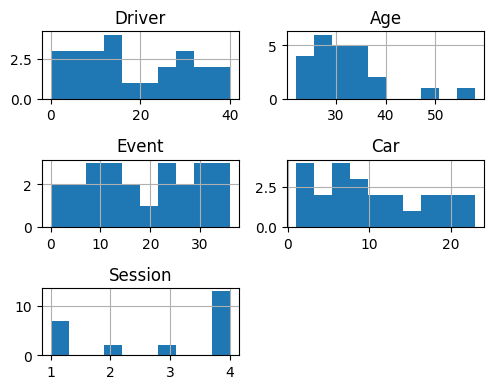

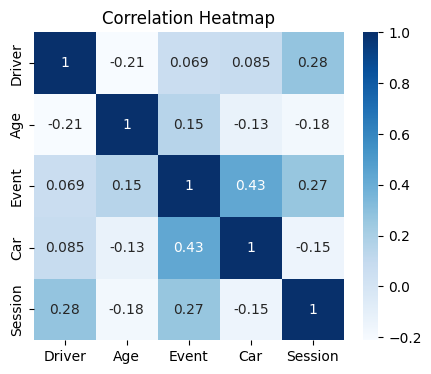

Random Forest Accuracy: 0.647

Prediction vs Actual (first 10 rows):
    Actual Session  Predicted Session
28               1                  4
8                1                  1
20               4                  4
2                1                  4
25               4                  4
31               3                  4
34               2                  1
6                4                  4
12               4                  4
39               4                  4


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

uploaded = files.upload()

df1 = pd.read_csv("fatal_accidents_drivers.csv")
df2 = pd.read_csv("fatal_accidents_marshalls.csv")
df3 = pd.read_csv("red_flags.csv")
df4 = pd.read_csv("safety_cars.csv")

for i, df in enumerate([df1, df2, df3, df4], 1):
    print(f"\nDataFrame df{i} info:")
    df.info()

df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)

for i, df in enumerate([df1, df2, df3, df4], 1):
    print(f"\nCleaned df{i} info:")
    df.info()

print(df1.columns)
print(df2.columns)
print(df3.columns)
print(df4.columns)

le = LabelEncoder()
df1['Driver'] = le.fit_transform(df1['Driver'])
df1['Event'] = le.fit_transform(df1['Event'])
df1['Car'] = le.fit_transform(df1['Car'])
df1['Session'] = le.fit_transform(df1['Session'])

x1 = df1.drop('Session', axis=1)
y1 = df1['Session'].astype(int)

session_counts = y1.value_counts()
valid_sessions = session_counts[session_counts >= 2].index
x1 = x1[y1.isin(valid_sessions)]
y1 = y1[y1.isin(valid_sessions)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_index in sss.split(x1, y1):
    x1_train = x1.iloc[train_index]
    x1_test = x1.iloc[test_index]
    y1_train = y1.iloc[train_index]
    y1_test = y1.iloc[test_index]

train_data1 = x1_train.join(y1_train)

numerical_train_data1 = train_data1.select_dtypes(include=np.number)
numerical_train_data1.hist(figsize=(5, 4))
plt.tight_layout()
plt.show()

train_data1['Session_ratio'] = train_data1['Session'] / train_data1['Driver'].replace(0, np.nan)
train_data1['Driver_age_ratio'] = train_data1['Driver'] / train_data1['Age'].replace(0, np.nan)
train_data1.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data1.fillna(0, inplace=True)

train_data1 = train_data1.join(pd.get_dummies(train_data1['Driver'], prefix='Driver'))
train_data1 = train_data1.join(pd.get_dummies(train_data1['Event'], prefix='Event'))
train_data1.drop(['Driver', 'Event'], axis=1, inplace=True)

plt.figure(figsize=(5, 4))
sns.heatmap(numerical_train_data1.corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

x1_train = train_data1.drop('Session', axis=1).apply(pd.to_numeric, errors='coerce').fillna(0)
y1_train = train_data1['Session'].astype(int)

test_data1 = x1_test.join(y1_test)
test_data1['Session_ratio'] = test_data1['Session'] / test_data1['Driver'].replace(0, np.nan)
test_data1['Driver_age_ratio'] = test_data1['Driver'] / test_data1['Age'].replace(0, np.nan)
test_data1.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data1.fillna(0, inplace=True)
test_data1 = test_data1.join(pd.get_dummies(test_data1['Driver'], prefix='Driver'))
test_data1 = test_data1.join(pd.get_dummies(test_data1['Event'], prefix='Event'))
test_data1.drop(['Driver', 'Event'], axis=1, inplace=True)
test_data1 = test_data1.reindex(columns=train_data1.columns, fill_value=0)

x1_test = test_data1.drop('Session', axis=1).apply(pd.to_numeric, errors='coerce').fillna(0)
y1_test = test_data1['Session'].astype(int)

forest = RandomForestClassifier(class_weight='balanced', random_state=42)
forest.fit(x1_train, y1_train)

print("Random Forest Accuracy:", round(forest.score(x1_test, y1_test), 3))

y1_pred = forest.predict(x1_test)

comparison_df = pd.DataFrame({
    'Actual Session': y1_test,
    'Predicted Session': y1_pred
})
print("\nPrediction vs Actual (first 10 rows):")
print(comparison_df.head(10))
